In [147]:
import mlxtend
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pandas_ml
from pandas_ml import ConfusionMatrix

In [148]:
import os
from sklearn.utils import shuffle
import glob
import sys
################### DATASET HANDLING ####################
DATASET_PATH = "/home/dic/jupyter/train_80v_data" #change the path to your dataset folder here

def parseDataset():
 
    #we use subfolders as class labels
    classes = [folder for folder in sorted(os.listdir(DATASET_PATH))]
 
    #now we enlist all image paths
    images = []
    for c in classes:
        images += ([os.path.join(DATASET_PATH, c, path) for path in os.listdir(os.path.join(DATASET_PATH, c))])
    #print(images)
    #shuffle image paths
    images = shuffle(images, random_state=80)
 
    #we want to use a 15% validation split
     vsplit = int(len(images) * 0.15)
    train = images[:-vsplit]
    val = images[-vsplit:]
    
    
    train = images[:vsplit] #everything except the last vsplit items in the array 
    val = images[vsplit:msplit]  #only last vsplit items from the array
    test=images[msplit:]
    #show some stats
    print ("CLASS LABELS:", classes)
    print ("TRAINING IMAGES:", len(train))
    print ("VALIDATION IMAGES:", len(val))
    print ("TEST IMAGES:", len(test))
    return classes, train, val,test
 
#parse dataset
CLASSES, TRAIN, VAL,TEST = parseDataset()


total: 38281
vsplit: 29859
tsplit: 8422
4211
CLASS LABELS: ['CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR']
TRAINING IMAGES: 29859
VALIDATION IMAGES: 4211
TEST IMAGES: 4211


In [149]:
import lasagne
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh

In [150]:
import os
import time
from sklearn.utils import shuffle

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools

from lasagne import random as lasagne_random
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
from lasagne import objectives
from lasagne import updates

import theano
import theano.tensor as T

import warnings
warnings.filterwarnings("ignore")


In [151]:
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
 
################## BUILDING THE MODEL ###################
def buildModel():
    #this is our input layer with the inputs (None, dimensions, width, height)
    l_input = layers.InputLayer((None, 3, 22, 23))
    
    #first convolutional layer, has l_input layer as incoming and is followed by a pooling layer
    l_conv1 = layers.Conv2DLayer(l_input, num_filters=32, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
    
    #l_pool = layers.MaxPool2DLayer(l_conv1, pool_size=2)
    
    l_drop1= layers.DropoutLayer(l_conv1,  p=0.1)
    
    #l_dense1 = layers.DenseLayer(l_drop1, num_units=128)
    
    #l_conv2 = layers.Conv2DLayer(l_drop1, num_filters=128, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
   
    #l_conv3 = layers.Conv2DLayer(l_conv2, num_filters=256, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_dense2 = layers.DenseLayer(l_drop1, num_units=128)
    
    l_drop2= layers.DropoutLayer(l_dense2,  p=0.25)
    
    l_dense2 = layers.DenseLayer(l_drop2, num_units=128)
    
    l_output = layers.DenseLayer(l_dense2, num_units=5, nonlinearity=lasagne.nonlinearities.softmax)
    
    #let's see how many params our net has
    print ("MODEL HAS", layers.count_params(l_output), "PARAMS")
    
    #we return the layer stack as our network by returning the last layer
    return l_output


NET = buildModel()


MODEL HAS 1738501 PARAMS


In [152]:
from lasagne import objectives
 
import theano
import theano.tensor as T
 
#################### LOSS FUNCTION ######################
def calc_loss(prediction, targets):
 
    #categorical crossentropy is the best choice for a multi-class softmax output
    l = T.mean(objectives.categorical_crossentropy(prediction, targets))
    
    return l
 
#theano variable for the class targets
#this is the output vector the net should predict
targets = T.matrix('targets', dtype=theano.config.floatX)
 
#get the network output
prediction = layers.get_output(NET)
 
#calculate the loss
loss = calc_loss(prediction, targets)

In [153]:
################# ACCURACY FUNCTION #####################
def calc_accuracy(prediction, targets):
 
    #we can use the lasagne objective categorical_accuracy to determine the top1 accuracy
    a = T.mean(objectives.categorical_accuracy(prediction, targets, top_k=1))
    
    return a
 
accuracy = calc_accuracy(prediction, targets)

In [154]:
from lasagne import updates
 
####################### UPDATES #########################
#get all trainable parameters (weights) of our net
params = layers.get_all_params(NET, trainable=True)
 
#we use the adam update
#it changes params based on our loss function with the learning rate
param_updates = updates.adam(loss, params, learning_rate=0.0003)

In [155]:
import theano
#################### TRAIN FUNCTION ######################
#the theano train functions takes images and class targets as input
#it updates the parameters of the net and returns the current loss as float value
#compiling theano functions may take a while, you might want to get a coffee now...
print ("COMPILING THEANO TRAIN FUNCTION...",)
train_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], loss, updates=param_updates)
print ("DONE!")
 
################# PREDICTION FUNCTION ####################
#we need the prediction function to calculate the validation accuracy
#this way we can test the net after training
#first we need to get the net output
net_output = layers.get_output(NET)
 
#now we compile another theano function; this may take a while, too
print ("COMPILING THEANO TEST FUNCTION...",)
test_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], [net_output, loss, accuracy])
print ("DONE!")

COMPILING THEANO TRAIN FUNCTION...
DONE!
COMPILING THEANO TEST FUNCTION...
DONE!


In [156]:
import cv2
import numpy as np
 
#################### BATCH HANDLING #####################
def loadImageAndTarget(path):
    #print(path)
    #here we open the image and scale it to 64x64 pixels
    img = cv2.imread(path)
    
    #print(path)
    img = cv2.resize(img, (22, 23))
    
    
    #OpenCV uses BGR instead of RGB, but for now we can ignore that
    #our image has the shape (64, 64, 3) but we need it to be (3, 64, 64)
    img = np.transpose(img, (2, 1, 0))
    
    #we want to use subfolders as class labels
    label = path.split(os.sep[-1])[-2]
    #print(label)
 
    #we need to get the index of our label from CLASSES
    index = CLASSES.index(label)
 
    #allocate array for target
    target = np.zeros((5), dtype='float32')
 
    #we set our target array = 1.0 at our label index, all other entries remain zero
    #Example: if label = dog and dog has index 2 in CLASSES, target looks like: [0.0, 0.0, 1.0, 0.0, 0.0]
    target[index] = 1.0
 
    #we need a 4D-vector for our image and a 2D-vector for our targets
    #we can adjust array dimension with reshape
    img = img.reshape(-1, 3, 22, 23)
    target = target.reshape(-1, 5)
 
    return img, target

In [157]:
#a reasonable size for one batch is 128
BATCH_SIZE = 250
def getDatasetChunk(split):
 
    #get batch-sized chunks of image paths
    for i in range(0, len(split), BATCH_SIZE):
        yield split[i:i+BATCH_SIZE]
        
def getNextImageBatch(split=TRAIN):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_b = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_b = np.zeros((BATCH_SIZE, 5), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        ib = 0
        for path in chunk:
            #load image data and class label from path
            x, y = loadImageAndTarget(path)
 
            #pack into batch array
            x_b[ib] = x
            y_b[ib] = y
            ib += 1
 
        #instead of return, we use yield
        yield x_b[:len(chunk)], y_b[:len(chunk)]

In [158]:

        
def getNextImageBatch1(split=TEST):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_T = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_T = np.zeros((BATCH_SIZE, 5), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        iT = 0
        for path in chunk:
            #load image data and class label from path
            x1, y1 = loadImageAndTarget(path)
 
            #pack into batch array
            x_T[iT] = x1
            y_T[iT] = y1
            iT += 1
 
        #instead of return, we use yield
        yield x_T[:len(chunk)], y_T[:len(chunk)]

In [159]:
cmatrix = []
def clearConfusionMatrix():

    global cmatrix

    #allocate empty matrix of size 5x5 (for our 5 classes)
    cmatrix = np.zeros((len(CLASSES), len(CLASSES)), dtype='int32')
    
    
def updateConfusionMatrix(t, p):
    
    global cmatrix
    cmatrix += confusion_matrix(np.argmax(t, axis=1), np.argmax(p, axis=1))
    
def showConfusionMatrix():

    #new figure
    plt.figure(1)
    plt.clf()

    #show matrix
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    #tick marks
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES)
    plt.yticks(tick_marks, CLASSES)

    #labels
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, cmatrix[i, j], 
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black")

    #axes labels
    plt.ylabel('Target label')
    plt.xlabel('Predicted label')

    #show
    plt.show()
    plt.pause(0.5)   


In [160]:
import matplotlib.pyplot as plt
 
##################### STAT PLOT #########################
plt.ion()
def showChart(epoch, t, v, a):
 
    #new figure
    plt.figure(0)
    plt.clf()
 
    #x-Axis = epoch
    e = range(0, epoch)
 
    #loss subplot
    plt.subplot(211)
    plt.plot(e, train_loss, 'r-', label='Train Loss')
    plt.plot(e, val_loss, 'b-', label='Val Loss')
    plt.ylabel('loss')
 
    #show labels
    plt.legend(loc='upper right', shadow=True)
 
    #accuracy subplot
    plt.subplot(212)
    plt.plot(e, val_accuracy, 'g-')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
 
    #show
    plt.show()
    plt.pause(0.5)

START TRAINING...
EPOCH: 1
TRAIN LOSS: 6.411120357718272
VAL LOSS: 1.222821500473743
VAL ACCURACY: 42.1 %
TIME: 54.8 s


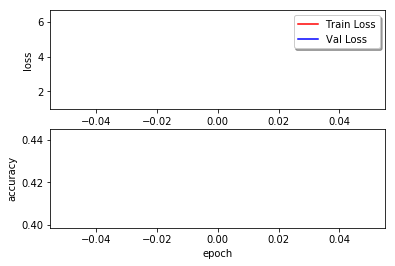

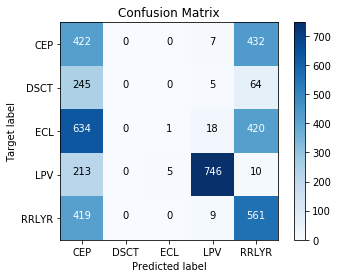

EPOCH: 2
TRAIN LOSS: 1.1160255697315071
VAL LOSS: 1.0748228915583147
VAL ACCURACY: 57.3 %
TIME: 53.7 s


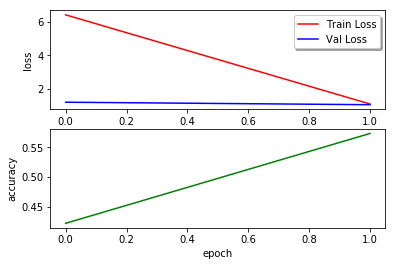

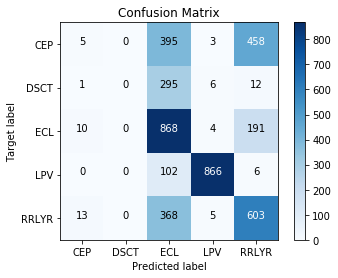

KeyboardInterrupt: 

In [161]:
import time
import sklearn
import numpy 
import matplotlib.pyplot as plt
import numpy as np
###################### TRAINING #########################
print ("START TRAINING...")
train_loss = []
val_loss = []
val_accuracy = []
for epoch in range(1,200):
 
    #start timer
    start = time.time()
    
    #reset confusion matrix
    clearConfusionMatrix()
 
    #iterate over train split batches and calculate mean loss for epoch
    t_l = []
    for image_batch, target_batch in getNextImageBatch():
 
        #calling the training functions returns the current loss
        l = train_net(image_batch, target_batch)
        t_l.append(l)
 
    #we validate our net every epoch and pass our validation split through as well
    v_l = []
    v_a = []
    for image_batch, target_batch in getNextImageBatch(VAL):
  
        #calling the test function returns the net output, loss and accuracy
        prediction_batch, l, a = test_net(image_batch, target_batch)
        v_l.append(l)
        v_a.append(a)
         
        #save predicions and targets for confusion matrix
        
        updateConfusionMatrix(target_batch,prediction_batch)
    
    #mlxtend confusion matrix
    #cm=confusion_matrix(target_batch,prediction_batch)
    #    fig,ax=plot_confusion_matrix(conf_mat=cm)
      #  plt.show()
        
        #pandas_ml confusion matrix
        #confusion_matrix1 = ConfusionMatrix(target_batch,prediction_batch)
        #print("Confusion matrix:\n%s" % confusion_matrix1)
        
    #stop timer
    end = time.time()
 
    #calculate stats for epoch
    train_loss.append(np.mean(t_l))
    val_loss.append(np.mean(v_l))
    val_accuracy.append(np.mean(v_a))
 
    #print stats for epoch
    print ("EPOCH:", epoch,)
    print ("TRAIN LOSS:", train_loss[-1],)
    print ("VAL LOSS:", val_loss[-1],)
    print ("VAL ACCURACY:", (int(val_accuracy[-1] * 1000) / 10.0), "%",)
    print ("TIME:", (int((end - start) * 10) / 10.0), "s")
 
    #show chart
    showChart(epoch, train_loss, val_loss, val_accuracy)
    
    #show confusion matrix
    showConfusionMatrix()

    #show best accuracy and epoch
print ("BEST VAL ACCURACY:", (int(max(val_accuracy) * 1000) / 10.0), "%", "EPOCH:", val_accuracy.index(max(val_accuracy)) + 1)

#####TESTING DATA#######
test_err = 0
test_acc = 0
test_batches = 0
for image_batch, target_batch in getNextImageBatch1():
    test_batch, err, acc = test_net(image_batch, target_batch)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
print ("TRAINING DONE!") 

In [73]:
from sklearn.utils.class_weight import compute_sample_weight
y =  ['ACEP', 'CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR', 'T2CEP']
compute_sample_weight(class_weight='unbalanced', y=y)

array([1., 1., 1., 1., 1., 1., 1.])

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1],
                      title='Confusion matrix')